<a href="https://colab.research.google.com/github/FatiBuuloloo/Assessment_of_Jakarta_Air_Pollution_Profiles_through_Clustering-Classification-mini_project_003/blob/main/clustering_(GMM)_%2B_classifying_(SVM)_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 003

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
from sklearn.impute import KNNImputer
import umap
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, silhouette_score, davies_bouldin_score,calinski_harabasz_score
from sklearn.ensemble import RandomForestClassifier
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

# Data Preparation

In [ ]:
url = "https://raw.githubusercontent.com/FatiBuuloloo/air_quality_index_prediction-mini_project_003/main/data-indeks-standar-pencemar-udara-(ispu)-di-provinsi-dki-jakarta-(1767755126895).csv"
data =pd.read_csv(url)

In [ ]:
data.columns.to_list()

['parameter_pencemar_kritis',
 'kategori',
 'periode_data',
 'bulan',
 'tanggal',
 'stasiun',
 'pm_sepuluh',
 'pm_duakomalima',
 'sulfur_dioksida',
 'karbon_monoksida',
 'ozon',
 'nitrogen_dioksida',
 'max']

In [ ]:
columns_mapping = {
    "parameter_pencemar_kritis": "critical_pollutant",
    "kategori": "category",
    "periode_data": "data_period",
    "bulan": "month",
    "tanggal": "date",
    "stasiun": "station",
    "pm_sepuluh": "PM10",
    "pm_duakomalima": "PM2.5",
    "sulfur_dioksida": "SO2",
    "karbon_monoksida": "CO",
    "ozon": "O3",
    "nitrogen_dioksida": "NO2",
    "max": "max_value"
}
data.rename(columns=columns_mapping,inplace =True)
data.columns

Index(['critical_pollutant', 'category', 'data_period', 'month', 'date',
       'station', 'PM10', 'PM2.5', 'SO2', 'CO', 'O3', 'NO2', 'max_value'],
      dtype='object')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3351 entries, 0 to 3350
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   critical_pollutant  3287 non-null   object 
 1   category            3350 non-null   object 
 2   data_period         3351 non-null   int64  
 3   month               3351 non-null   int64  
 4   date                3351 non-null   int64  
 5   station             3351 non-null   object 
 6   PM10                3101 non-null   float64
 7   PM2.5               3291 non-null   float64
 8   SO2                 3296 non-null   float64
 9   CO                  3303 non-null   float64
 10  O3                  3306 non-null   float64
 11  NO2                 3283 non-null   float64
 12  max_value           3343 non-null   float64
dtypes: float64(7), int64(3), object(3)
memory usage: 340.5+ KB


In [ ]:
data["year"] = data["data_period"].apply(lambda x: int(str(x)[:4]))
data = data.rename(columns={"date":"day"})
date_string = (
    data["year"].astype(str) + "-" +
    data["month"].astype(str) + "-" +
    data["day"].astype(str)
)

data["date_complete"] = pd.to_datetime(date_string, errors='coerce')
data.dropna(subset=["date_complete"], inplace=True)

In [ ]:
data=data.drop(columns=["data_period", "year","month","day"],axis=1)
data=data.rename(columns={"date_complete":"date"})

In [ ]:
obj_cols = data.select_dtypes("object")
for item in obj_cols:
 print(f"Column {item} : {data[item].unique()}")
 print()

Column critical_pollutant : [nan 'PM25' 'SO2' 'PM10' 'O3' 'CO' 'NO2']

Column category : ['SEDANG' 'BAIK' 'TIDAK SEHAT' 'TIDAK ADA DATA' 'SANGAT TIDAK SEHAT']

Column station : ['DKI3  Jagakarsa' 'DKI1  Bunderan HI' 'DKI2 Kelapa Gading'
 'DKI3 Jagakarsa' 'DKI4 Lubang Buaya' 'DKI2  Kelapa Gading'
 'DKI1  Bundaran Hotel Indonesia (HI)' 'DKI4  Lubang Buaya'
 'DKI5  Kebon Jeruk  Jakarta Barat' 'DKI5 Kebon Jeruk'
 'DKI1 Bundaran Hotel Indonesia (HI)' 'DKI5 Kebon Jeruk Jakarta Barat'
 'DKI1 Bundaran Hotel Indonesia  HI']



In [ ]:
category_mapping = {
    "BAIK": "GOOD",
    "SEDANG": "MODERATE",
    "TIDAK SEHAT": "UNHEALTHY",
    "SANGAT TIDAK SEHAT": "VERY UNHEALTHY",
    "TIDAK ADA DATA": "NO DATA"
}

In [ ]:
data["category"] = data["category"].apply(lambda x: category_mapping[x] if x in category_mapping else x)

In [ ]:
data.category.value_counts()

category
MODERATE          2604
GOOD               386
UNHEALTHY          340
NO DATA             19
VERY UNHEALTHY       1
Name: count, dtype: int64

In [ ]:
def station_norm(name_stat):
    if "DKI1" in name_stat:
        return "DKI1 Bundaran HI"
    elif "DKI2" in name_stat:
        return "DKI2 Kelapa Gading"
    elif "DKI3" in name_stat:
        return "DKI3 Jagakarsa"
    elif "DKI4" in name_stat:
        return "DKI4 Lubang Buaya"
    elif "DKI5" in name_stat:
        return "DKI5 Kebon Jeruk"

In [ ]:
data["station"] = data["station"].apply(station_norm)
data["station"].unique()

array(['DKI3 Jagakarsa', 'DKI1 Bundaran HI', 'DKI2 Kelapa Gading',
       'DKI4 Lubang Buaya', 'DKI5 Kebon Jeruk'], dtype=object)

# Preprocessing Data

In [ ]:
data[data["category"]=="VERY UNHEALTHY"]

critical_pollutant        category         station  PM10  PM2.5   SO2  \
519                NaN  VERY UNHEALTHY  DKI3 Jagakarsa  43.0   55.0  51.0   

       CO    O3    NO2  max_value       date  
519  10.0  20.0  202.0      202.0 2024-02-14

In [ ]:
data["category"] = data["category"].apply(lambda x: x.replace("VERY UNHEALTHY","UNHEALTHY") if x=="VERY UNHEALTHY" else x)
data["category"].value_counts()

category
MODERATE     2604
GOOD          386
UNHEALTHY     341
NO DATA        19
Name: count, dtype: int64

Handling Missing Value

In [ ]:
data = data[data["category"] != "NO DATA"].reset_index(drop=True)
pd.DataFrame({
    "Total Missing Value": data.isnull().sum(),
    "Missing value percentage (%)": data.isnull().mean() * 100
})

Total Missing Value  Missing value percentage (%)
critical_pollutant                   44                      1.320925
category                              0                      0.000000
station                               0                      0.000000
PM10                                230                      6.904833
PM2.5                                40                      1.200841
SO2                                  35                      1.050736
CO                                   28                      0.840588
O3                                   25                      0.750525
NO2                                  48                      1.441009
max_value                             0                      0.000000
date                                  0                      0.000000

In [ ]:
cols_to_fillna = ["PM10","PM2.5",
"SO2","CO", "O3", "NO2"]
data[cols_to_fillna].describe()

PM10        PM2.5          SO2           CO           O3  \
count  3101.000000  3291.000000  3296.000000  3303.000000  3306.000000   
mean     49.627540    72.233364    36.039442    15.277021    24.065638   
std      16.301621    23.083598    16.080364     6.815860    12.955116   
min       5.000000    10.000000     3.000000     2.000000     2.000000   
25%      38.000000    57.000000    24.000000    10.000000    15.000000   
50%      52.000000    74.000000    32.000000    14.000000    22.000000   
75%      60.000000    88.000000    53.000000    20.000000    29.000000   
max     187.000000   157.000000   112.000000    70.000000   115.000000   

               NO2  
count  3283.000000  
mean     27.319829  
std      16.810557  
min       1.000000  
25%      15.000000  
50%      24.000000  
75%      37.000000  
max     202.000000

In [ ]:
imputer = KNNImputer(n_neighbors=5)
data[cols_to_fillna] = imputer.fit_transform(data[cols_to_fillna])
data_copy = data[cols_to_fillna].copy()
data_copy

PM10  PM2.5   SO2    CO    O3   NO2
0     51.0   65.0  45.0   9.0   8.0  79.0
1     27.0   34.0  45.0   5.0   8.0  56.0
2     40.2   52.0  46.0   6.0   9.0  51.0
3     46.0   65.0  46.0   8.0   9.0  38.0
4     37.0   55.0  47.0   7.0  11.0  28.0
...    ...    ...   ...   ...   ...   ...
3326  35.0   56.0  26.0   7.0  36.0  26.0
3327  53.0   89.0  28.0  14.0  28.0  49.0
3328  57.0   79.0  30.0   9.0  32.0  41.0
3329  47.0   64.0  30.0   9.0  31.0  36.0
3330  53.0   82.0  28.0  18.0  33.0  46.0

[3331 rows x 6 columns]

In [ ]:
pollution_dict={
"PM10":"PM_10",
"PM2.5":"PM_25",
"SO2" : "SO2",
"CO" : "CO",
"O3" : "O3",
"NO2" : "NO2"
}

for idx, item in data["critical_pollutant"].items():
    if pd.isna(data.loc[idx, "critical_pollutant"]):
        colomn_name = None
        thres_value = 0
        for item in cols_to_fillna:
            if data.loc[idx,item]>thres_value:
                thres_value=data.loc[idx,item]
                colomn_name = item
        #print(pollution_dict[nama_kolom])
        data.loc[idx,"critical_pollutant"]=pollution_dict[colomn_name]

In [ ]:
data.isna().sum()

critical_pollutant    0
category              0
station               0
PM10                  0
PM2.5                 0
SO2                   0
CO                    0
O3                    0
NO2                   0
max_value             0
date                  0
dtype: int64

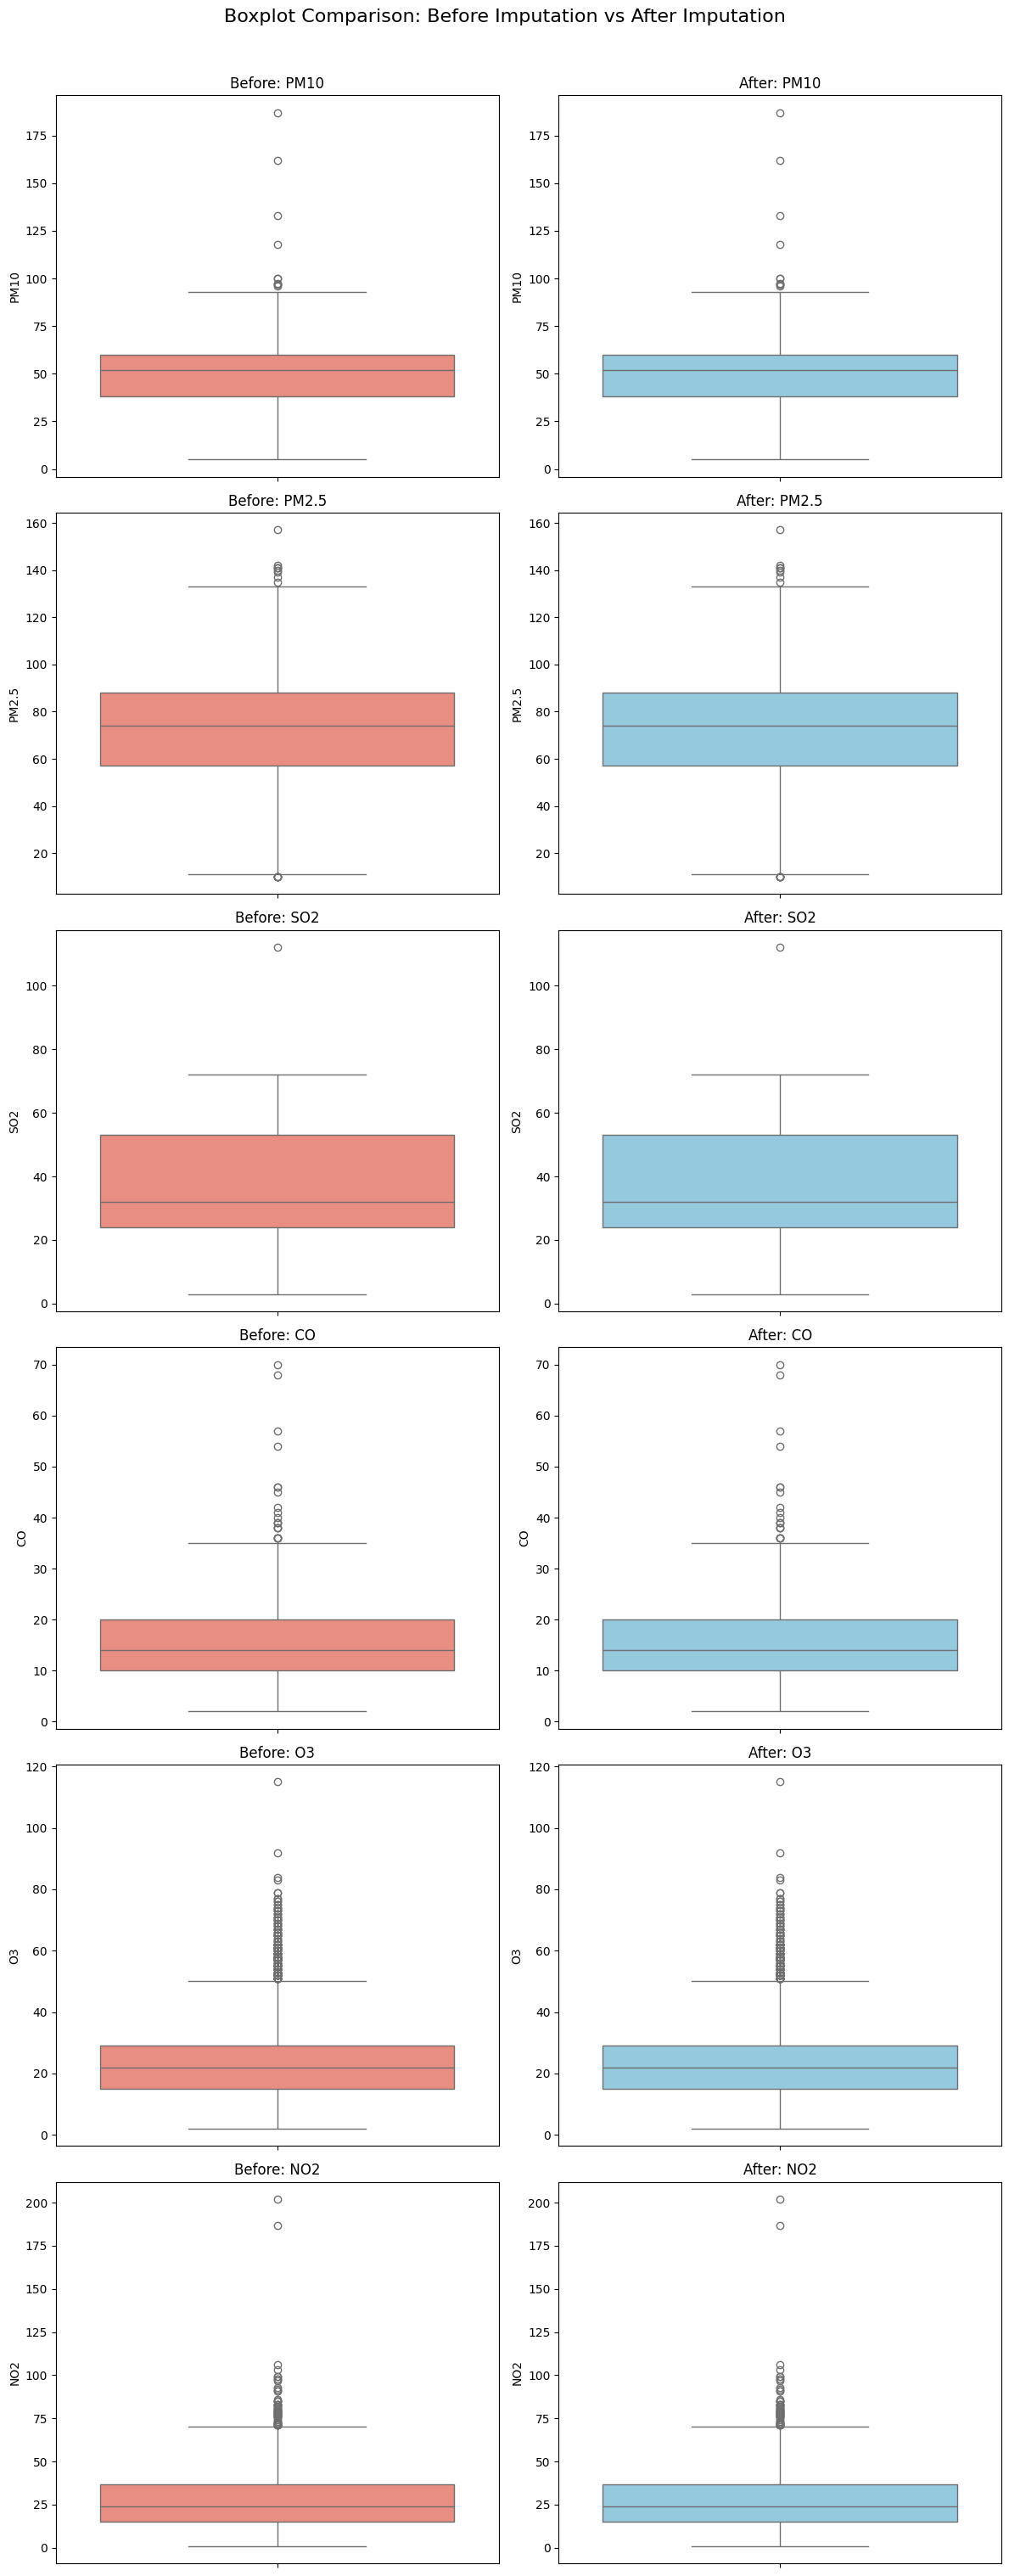

In [ ]:
nrows = len(cols_to_fillna)
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(12, 5 * nrows))
fig.suptitle('Boxplot Comparison: Before Imputation vs After Imputation', fontsize=16, y=1.01)

for i, col in enumerate(cols_to_fillna):
    sns.boxplot(y=data[col], ax=axes[i, 0], color='salmon')
    axes[i, 0].set_title(f'Before: {col}')
    sns.boxplot(y=data_copy[col], ax=axes[i, 1], color='skyblue')
    axes[i, 1].set_title(f'After: {col}')

plt.tight_layout()
plt.show()

In [ ]:
data.iloc[:,0].value_counts()

critical_pollutant
PM25     2837
SO2       198
PM10      176
NO2        65
O3         52
PM_25       2
CO          1
Name: count, dtype: int64

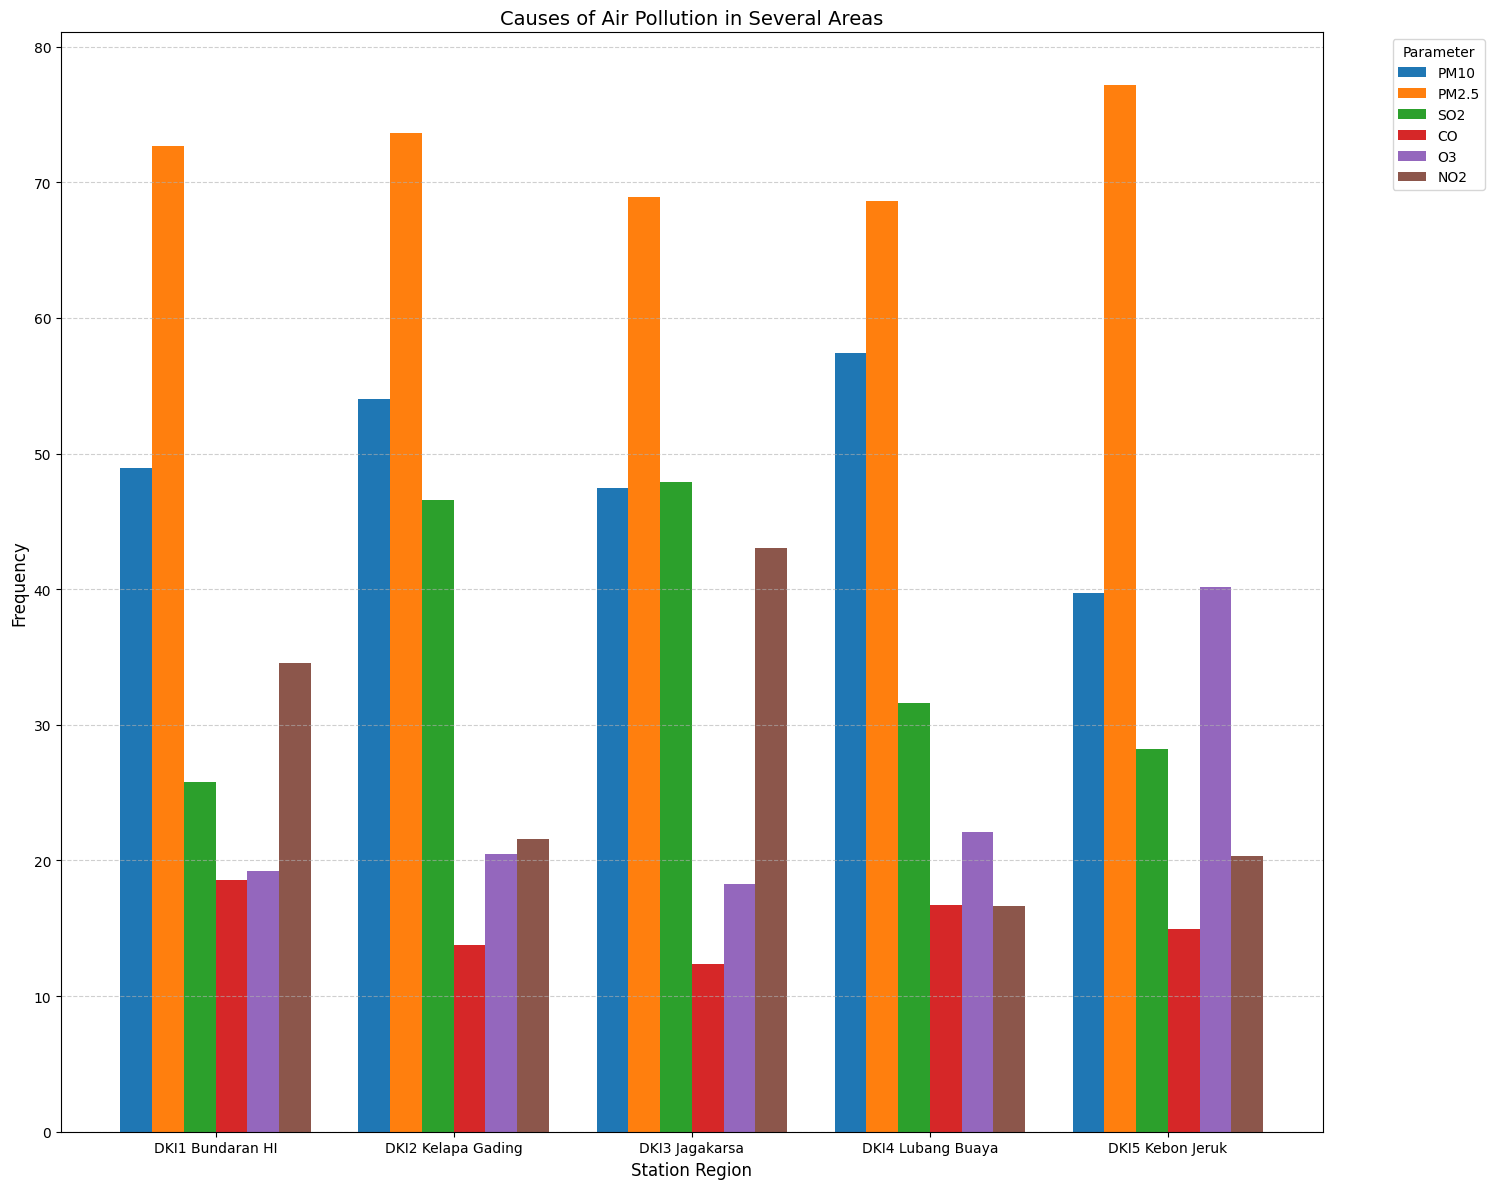

In [ ]:
cluster_info = data.groupby("station")[cols_to_fillna].agg("mean")
ax = cluster_info.plot(kind='bar', figsize=(15, 12), width=0.8)
plt.title("Causes of Air Pollution in Several Areas", fontsize=14)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Station Region', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Parameter', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

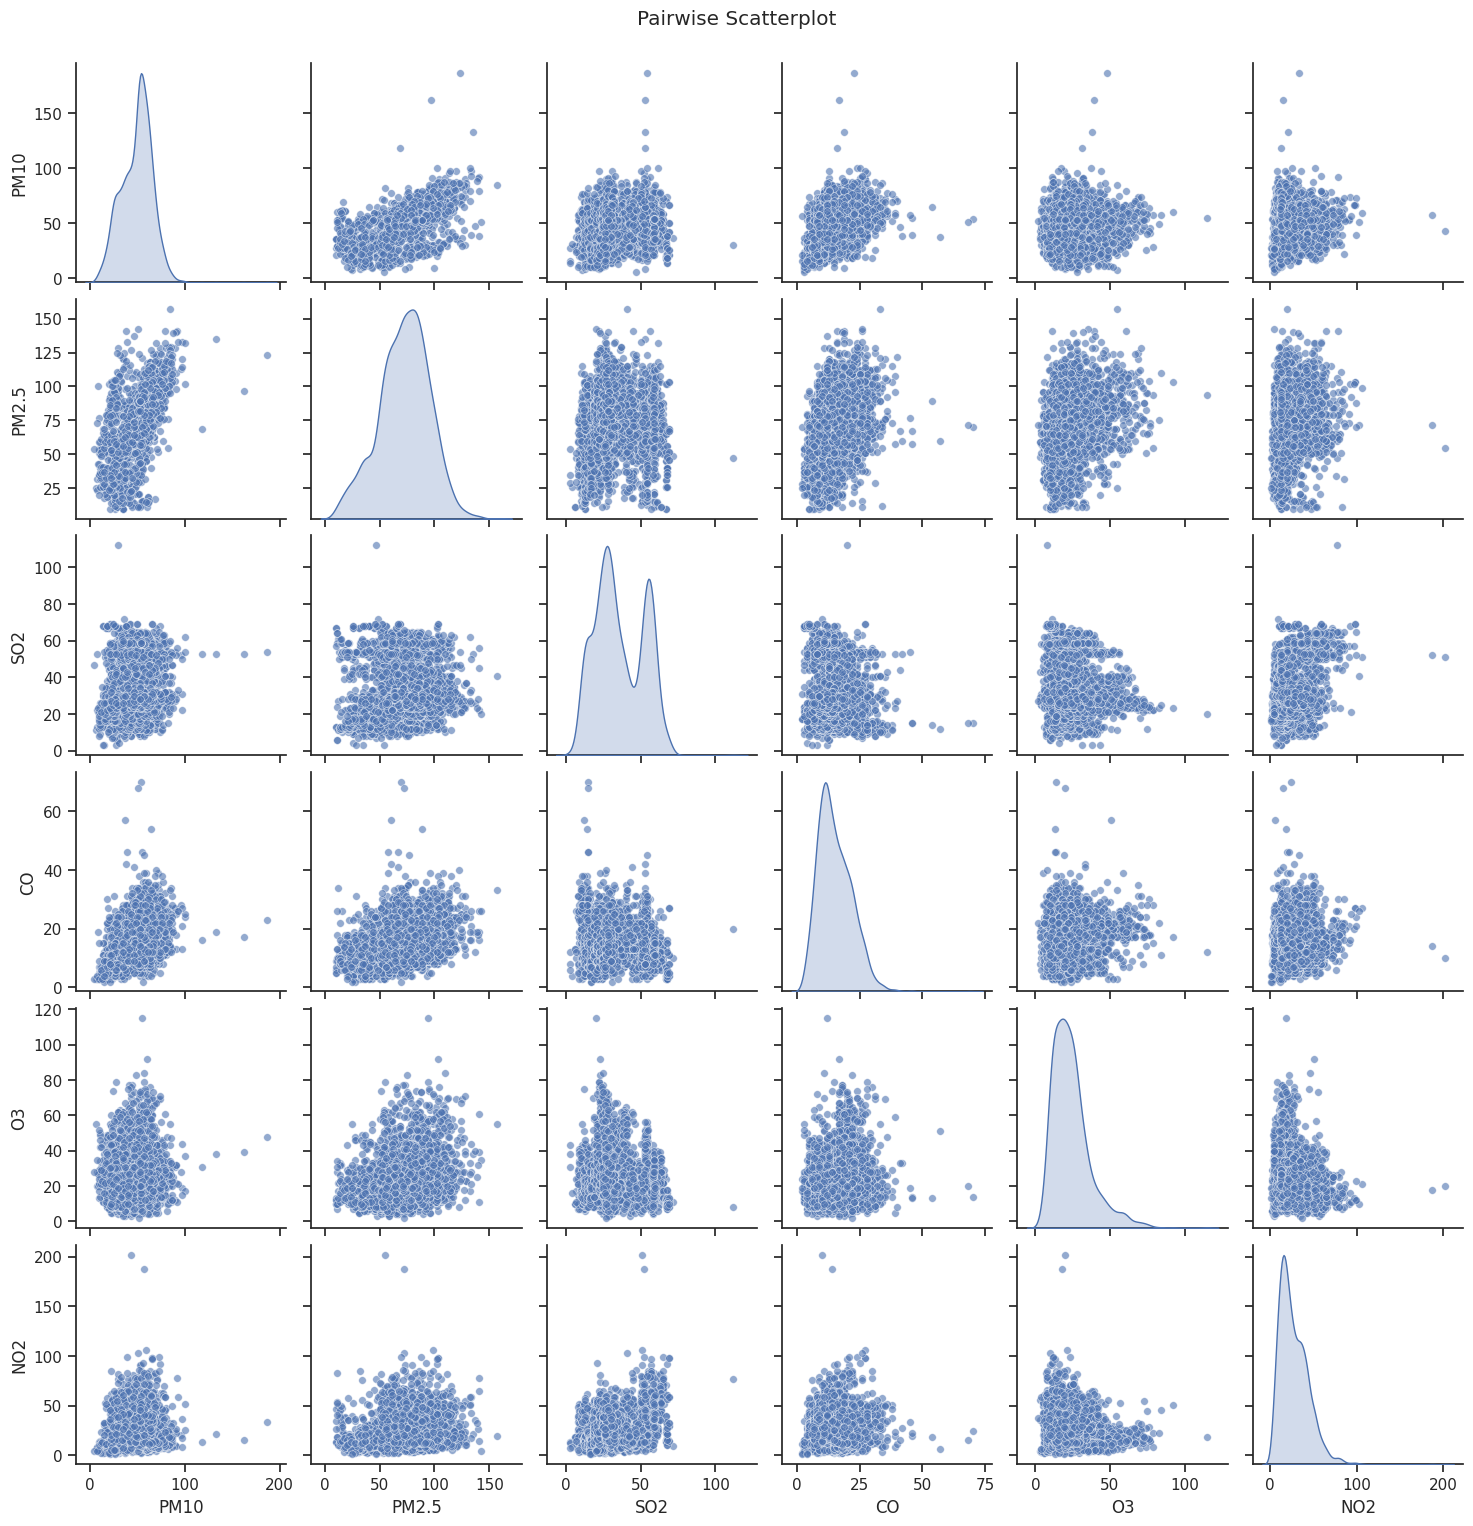

In [ ]:
sns.set_theme(style="ticks")
pair_plot = sns.pairplot(data_copy, diag_kind='kde', plot_kws={'alpha': 0.6, 's': 30})

pair_plot.fig.suptitle("Pairwise Scatterplot", y=1.02)

plt.show()

In [ ]:
for item in cols_to_fillna:
  print(f"{item} Skewness: {data_copy[item].skew()}")

PM10 Skewness: 0.11730479343737744
PM2.5 Skewness: -0.22711112857370477
SO2 Skewness: 0.22116613540078836
CO Skewness: 1.0004968789752189
O3 Skewness: 1.4275678432158916
NO2 Skewness: 1.4873409553170223


Yeo-Johnson Transformation

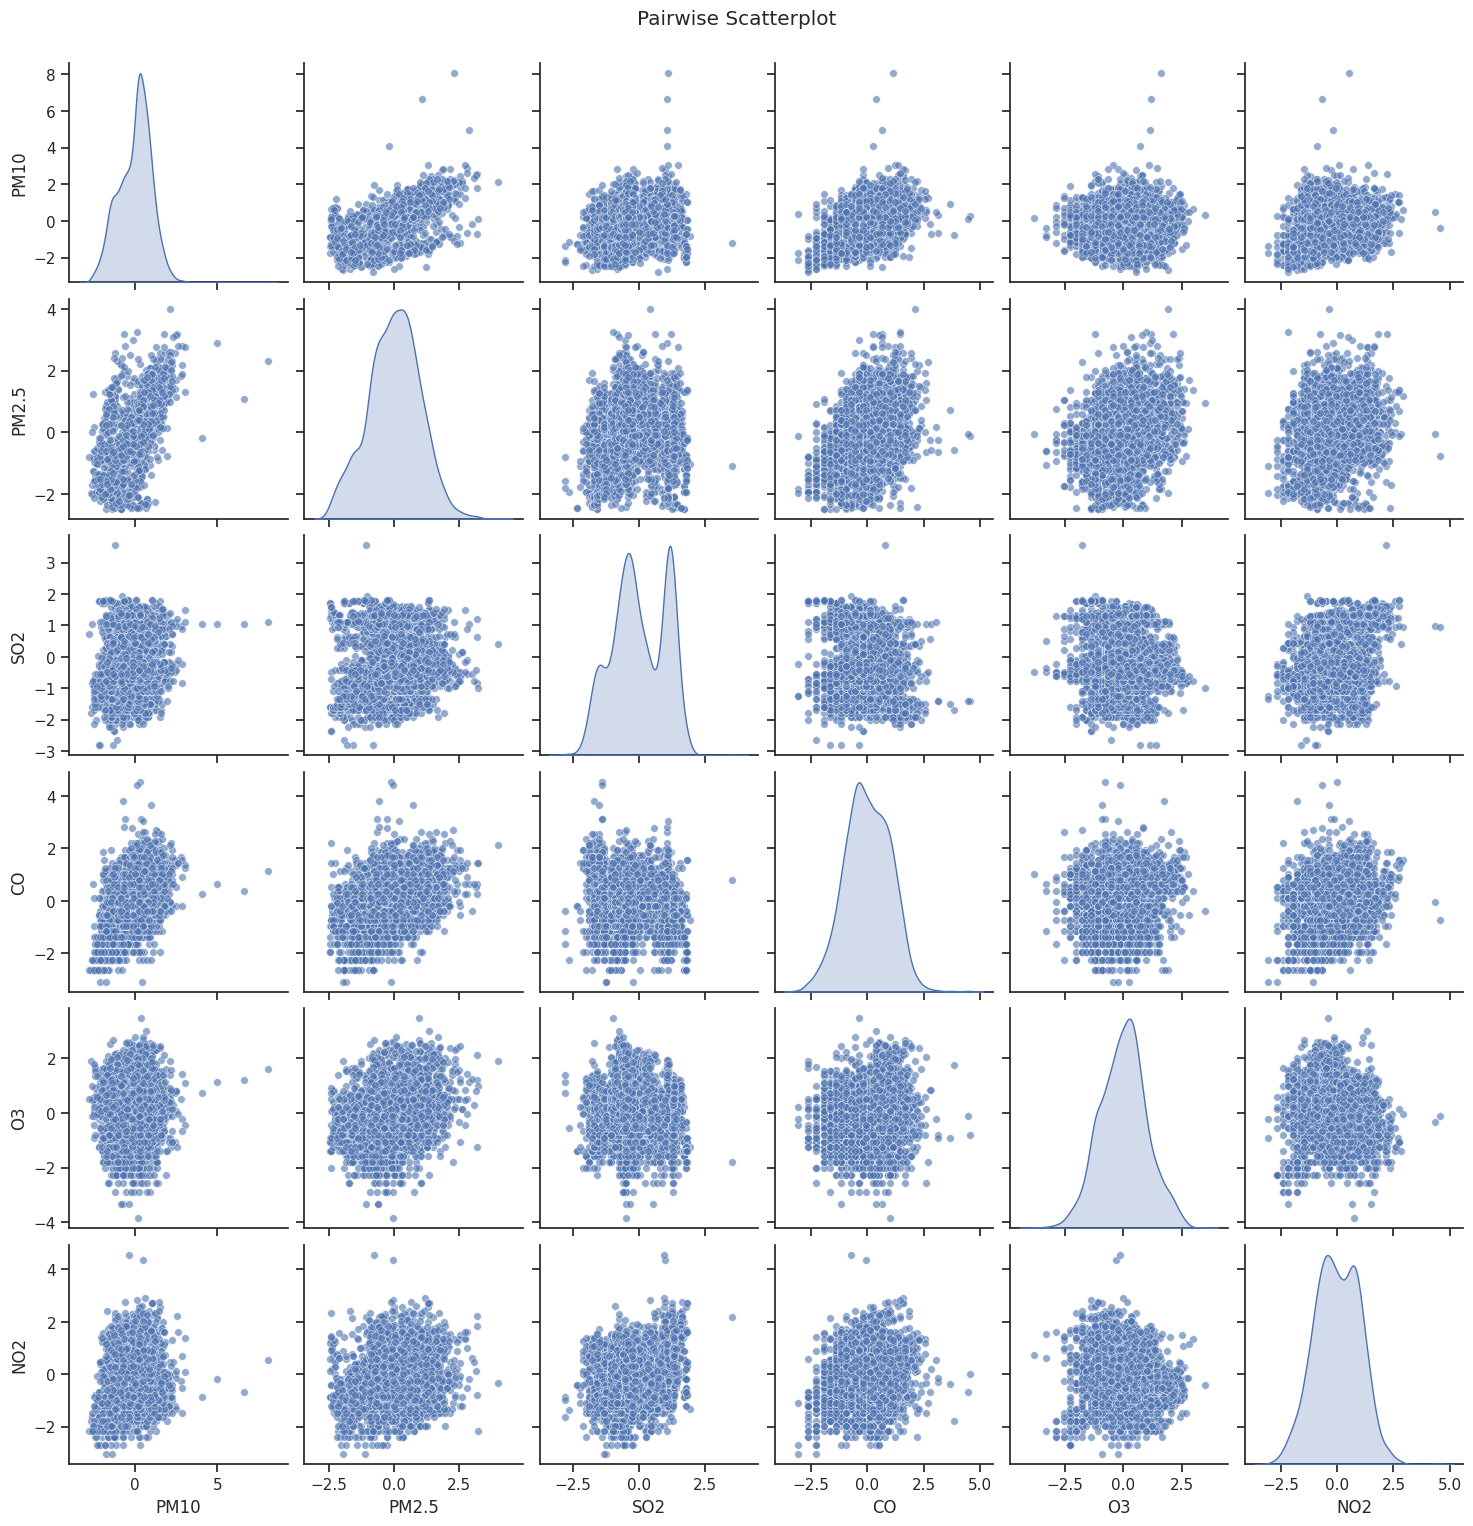

In [ ]:
pt = PowerTransformer(method='yeo-johnson', standardize=True)

X_transformed = pt.fit_transform(data_copy)
X_scaled_YJ = pd.DataFrame(X_transformed, columns=cols_to_fillna)

sns.set_theme(style="ticks")
pair_plot = sns.pairplot(X_scaled_YJ, diag_kind='kde', plot_kws={'alpha': 0.6, 's': 30})
pair_plot.fig.suptitle("Pairwise Scatterplot", y=1.02)
plt.show()

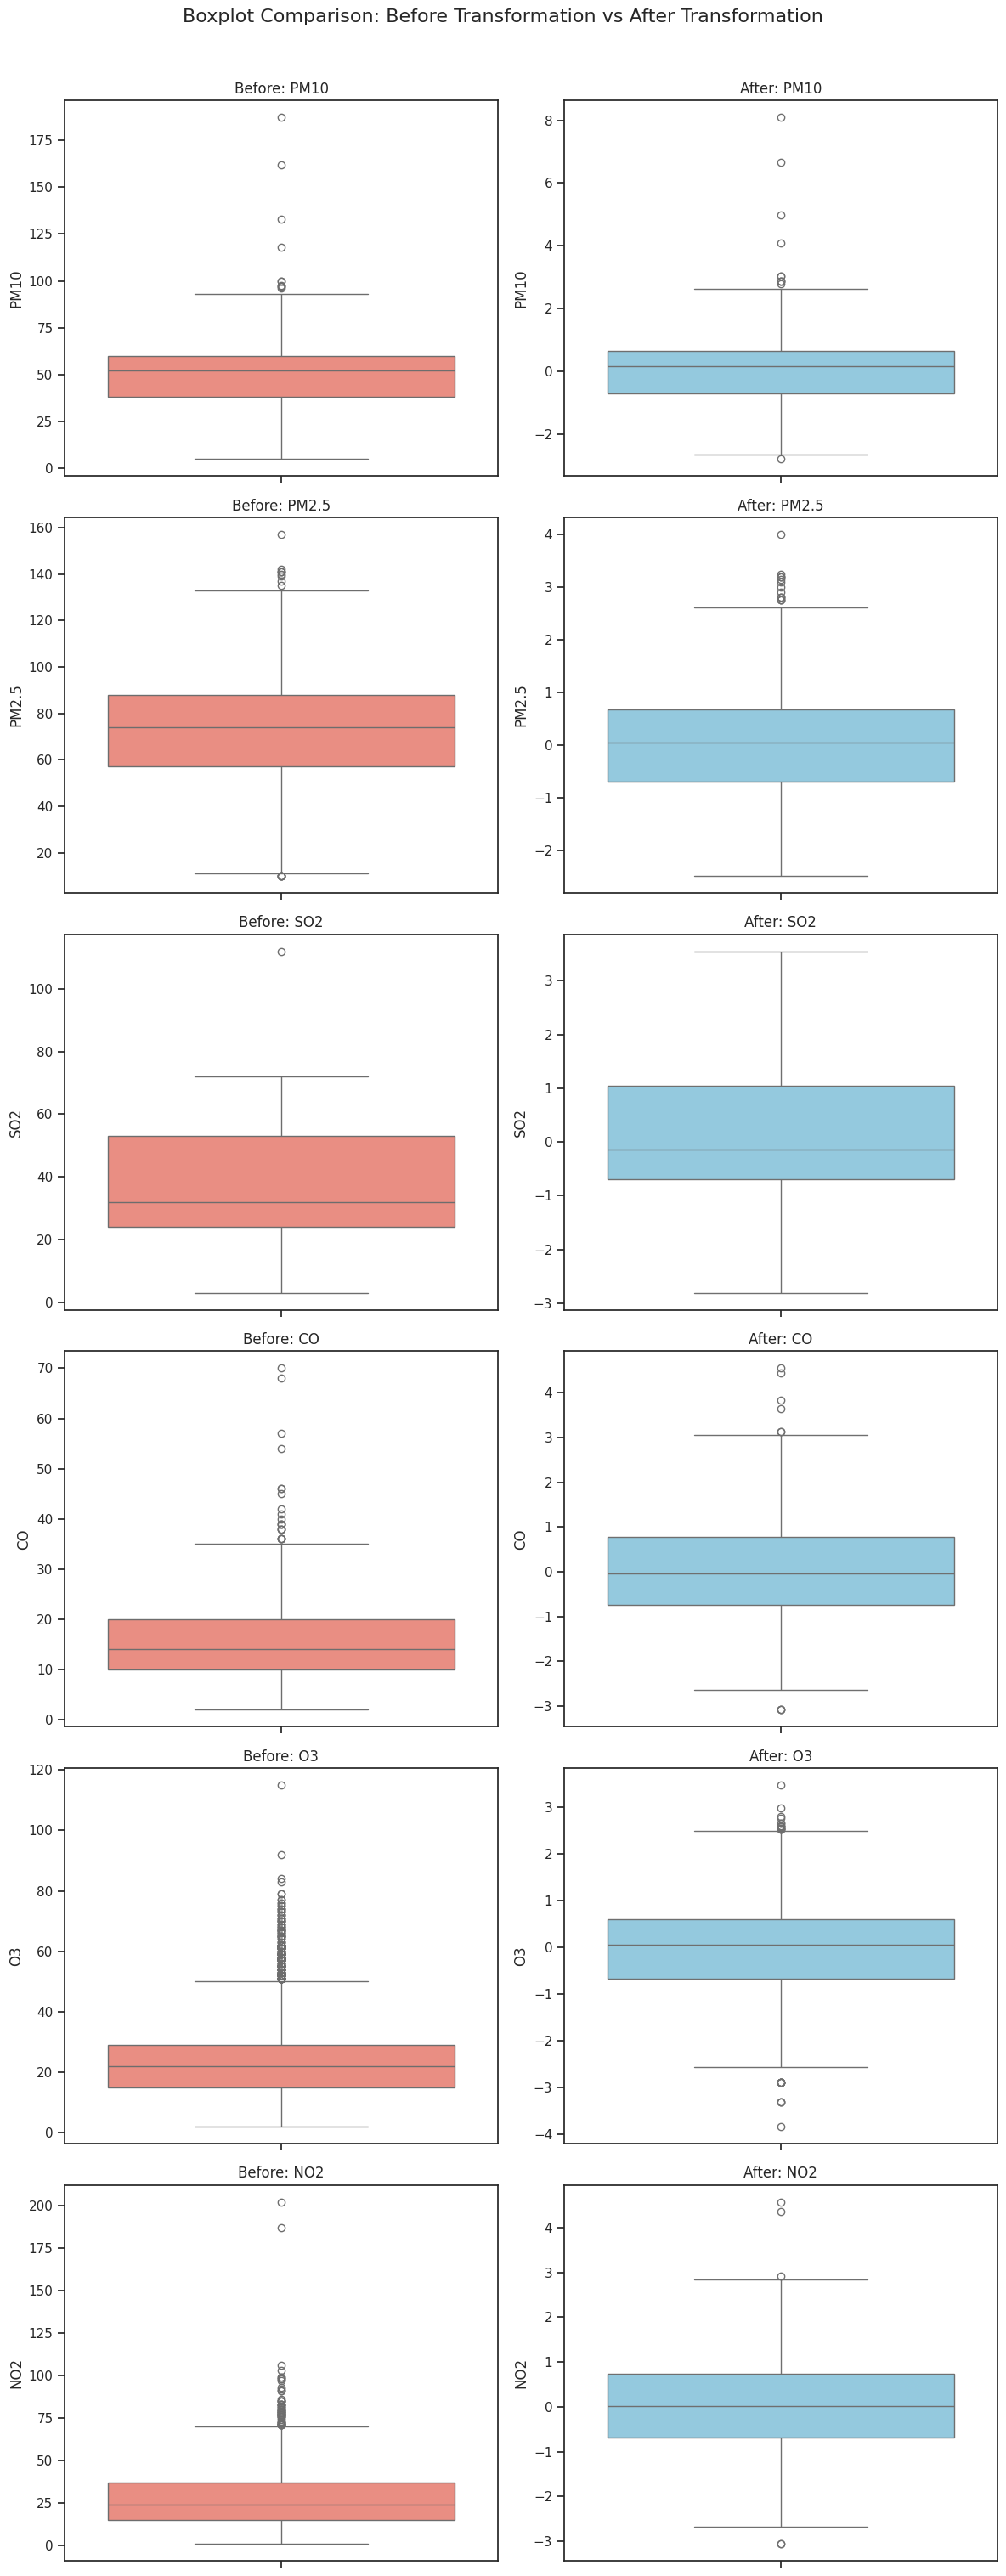

In [ ]:
nrows = len(cols_to_fillna)
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(12, 5 * nrows))
fig.suptitle('Boxplot Comparison: Before Transformation vs After Transformation', fontsize=16, y=1.01)

for i, col in enumerate(cols_to_fillna):
    sns.boxplot(y=data[col], ax=axes[i, 0], color='salmon')
    axes[i, 0].set_title(f'Before: {col}')
    sns.boxplot(y=X_scaled_YJ[col], ax=axes[i, 1], color='skyblue')
    axes[i, 1].set_title(f'After: {col}')

plt.tight_layout()
plt.show()

In [ ]:
def count_outliers(df, columns):
    outlier_report = {}
    for item in columns:
        Q1 = df[item].quantile(0.25)
        Q3 = df[item].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[item] < lower_bound) | (df[item] > upper_bound)]
        outlier_report[item] = len(outliers)

    return pd.Series(outlier_report)
num_outlier = count_outliers(X_scaled_YJ, ['PM10', 'PM2.5', 'SO2', 'CO', 'O3', 'NO2'])
print("Total outliers for each column")
print(num_outlier)

Total outliers for each column
PM10     11
PM2.5    15
SO2       0
CO        9
O3       26
NO2       5
dtype: int64


In [ ]:
for item in cols_to_fillna:
    Q1 = X_scaled_YJ[item].quantile(0.25)
    Q3 = X_scaled_YJ[item].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    X_scaled_YJ = X_scaled_YJ[~((X_scaled_YJ[item] < lower_bound) | (X_scaled_YJ[item] > upper_bound))]

In [ ]:
num_outlier1 = count_outliers(X_scaled_YJ, ['PM10', 'PM2.5', 'SO2', 'CO', 'O3', 'NO2'])
print("Total outliers for each column")
print(num_outlier1)

Total outliers for each column
PM10     0
PM2.5    0
SO2      0
CO       0
O3       0
NO2      0
dtype: int64


In [ ]:
for item in cols_to_fillna:
  print(f"{item} Skewness: {X_scaled_YJ[item].skew()}")

PM10 Skewness: -0.3117371780602579
PM2.5 Skewness: -0.16244520949946248
SO2 Skewness: -0.0976834217326264
CO Skewness: -0.060812113720000185
O3 Skewness: 0.018105401026679298
NO2 Skewness: -0.04639661620992629


Box Cox Transformation

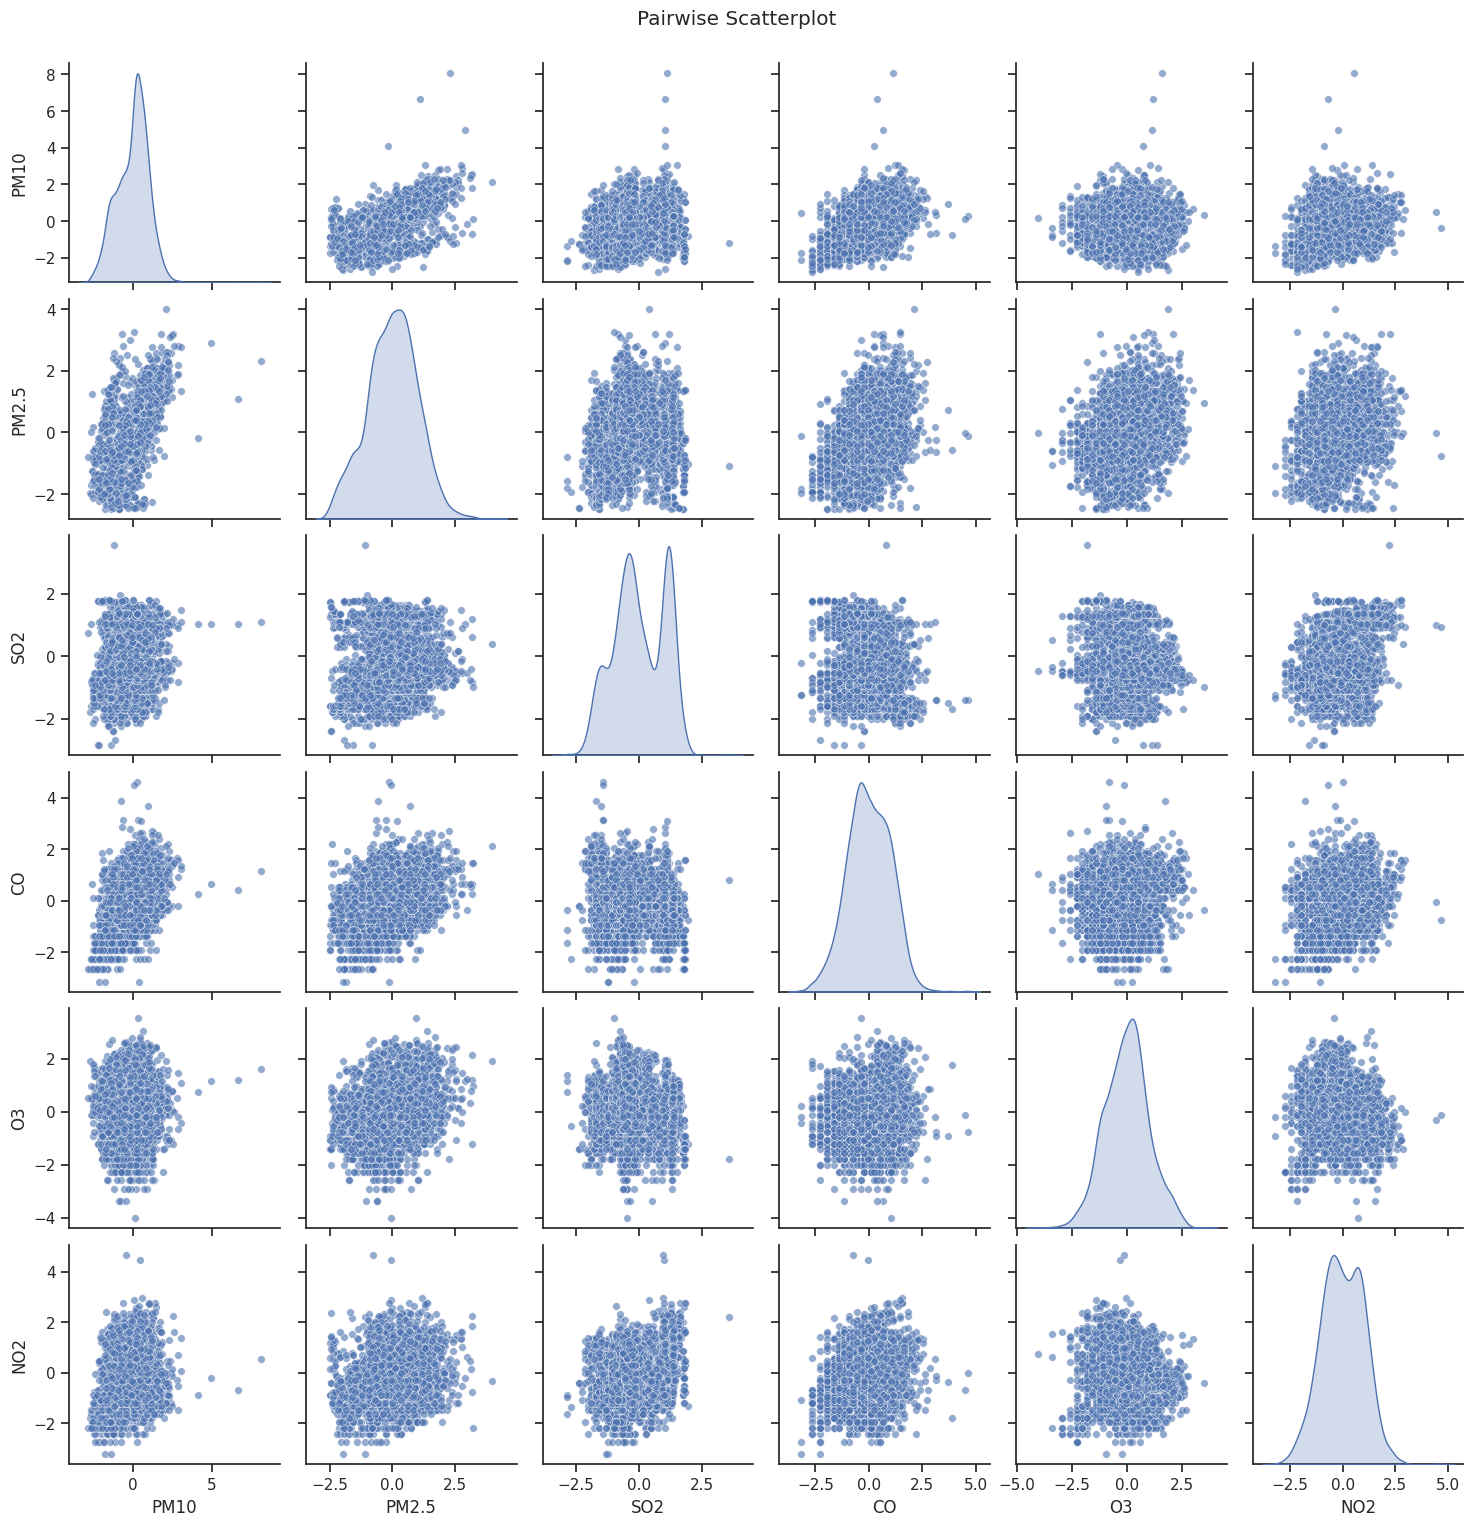

In [ ]:
pt_box= PowerTransformer(method='box-cox',standardize=True)
X_transformed_box = pt_box.fit_transform(data_copy)
X_scaled_BC = pd.DataFrame(X_transformed_box, columns=cols_to_fillna)

sns.set_theme(style="ticks")
pair_plot = sns.pairplot(X_scaled_BC, diag_kind='kde', plot_kws={'alpha': 0.6, 's': 30})
pair_plot.fig.suptitle("Pairwise Scatterplot", y=1.02)

plt.show()

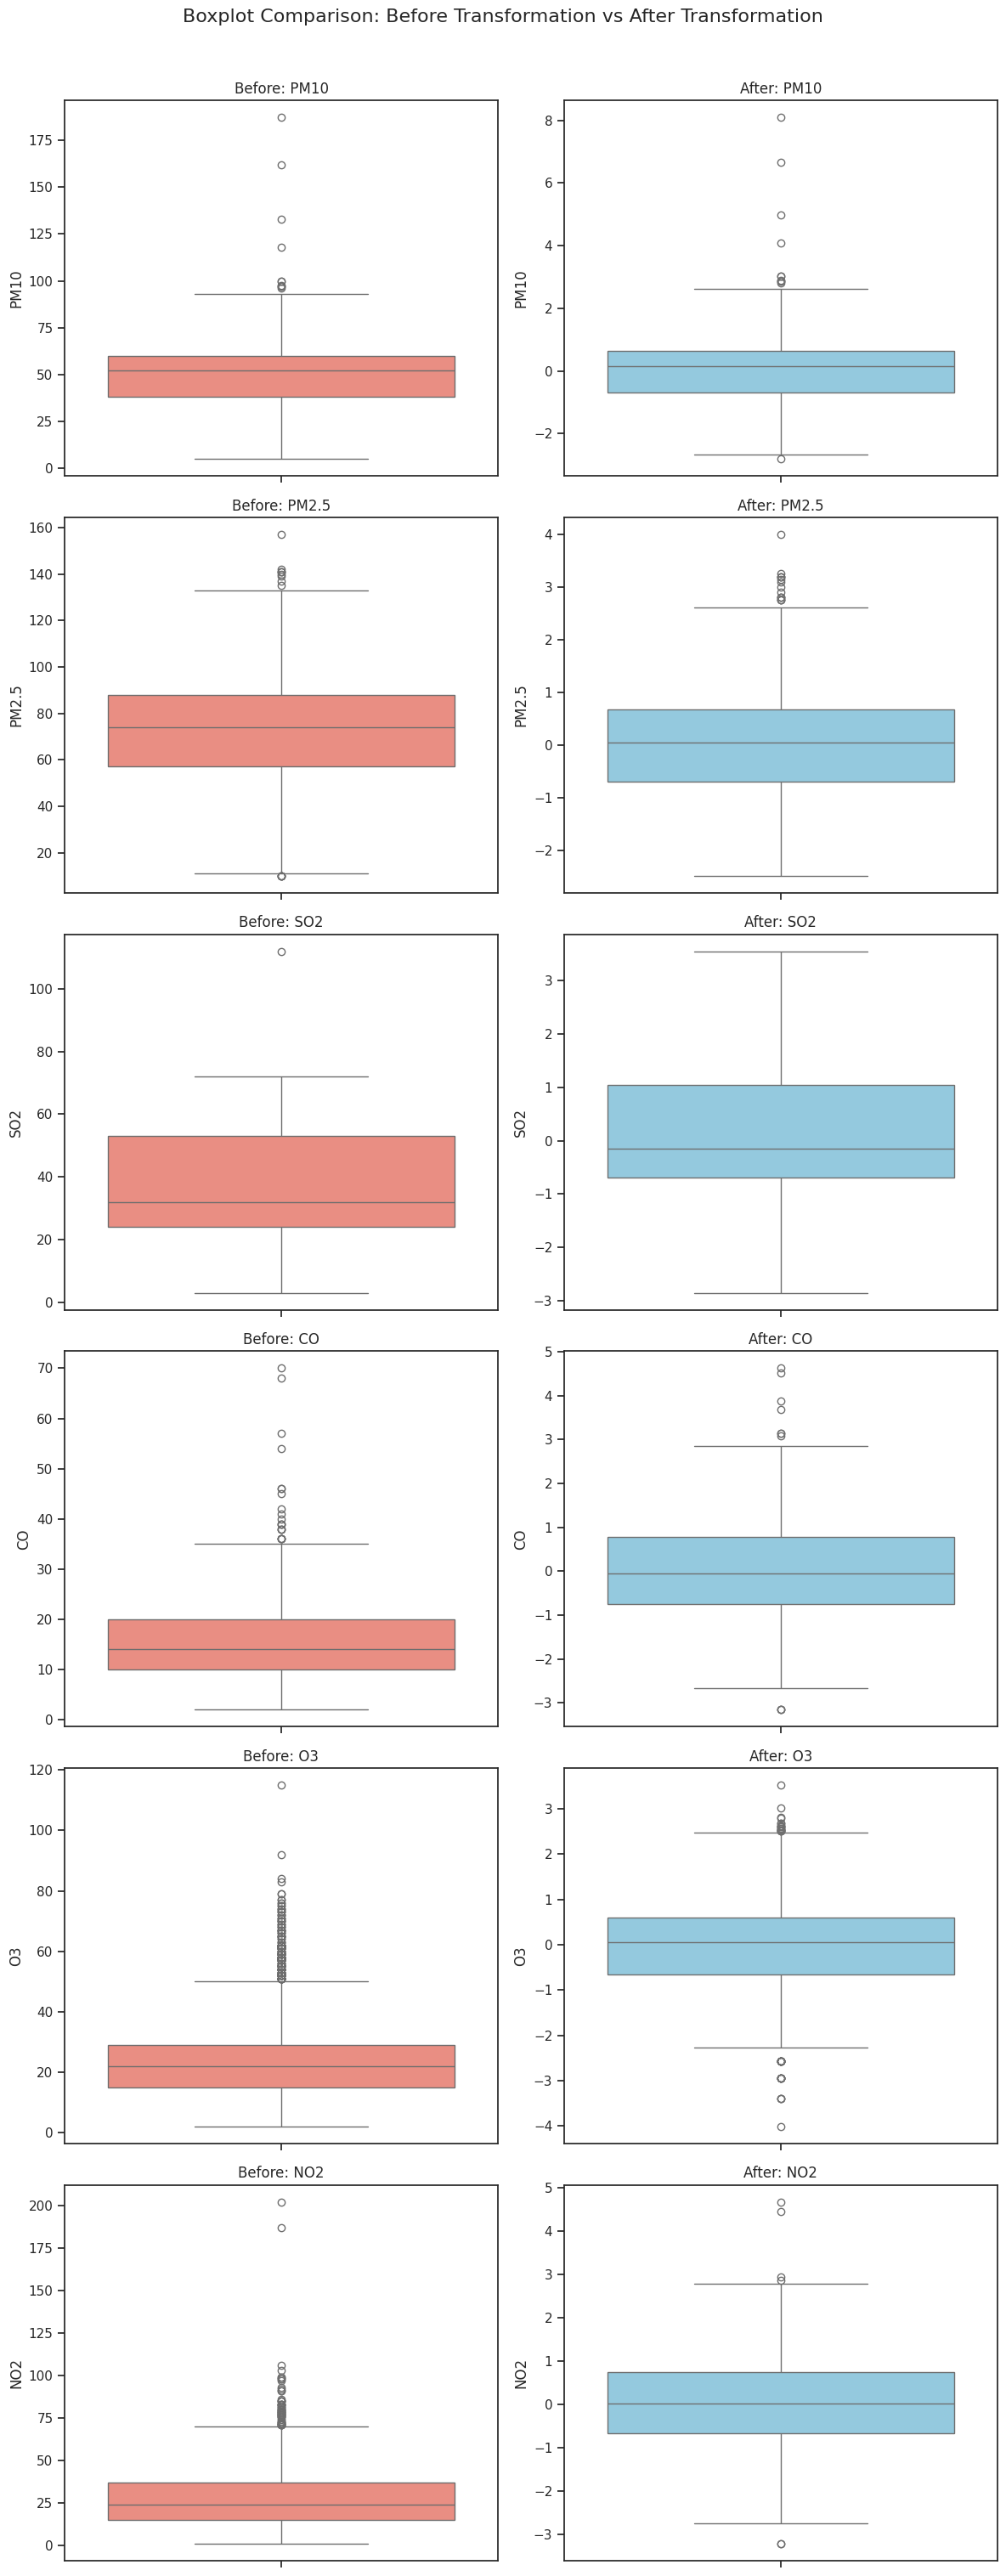

In [ ]:
nrows = len(cols_to_fillna)
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(12, 5 * nrows))
fig.suptitle('Boxplot Comparison: Before Transformation vs After Transformation', fontsize=16, y=1.01)

for i, col in enumerate(cols_to_fillna):
    sns.boxplot(y=data[col], ax=axes[i, 0], color='salmon')
    axes[i, 0].set_title(f'Before: {col}')
    sns.boxplot(y=X_scaled_BC[col], ax=axes[i, 1], color='skyblue')
    axes[i, 1].set_title(f'After: {col}')

plt.tight_layout()
plt.show()

In [ ]:
for item in cols_to_fillna:
  print(f"{item} Skewness: {X_scaled_BC[item].skew()}")

PM10 Skewness: 0.04304761598919486
PM2.5 Skewness: -0.05510954982363334
SO2 Skewness: -0.0905191410958311
CO Skewness: -0.0031756575807534754
O3 Skewness: 0.0010547100168888047
NO2 Skewness: -0.015093722291402382


UMAP (Uniform Manifold Approximation and Projection) Dimension Reduction

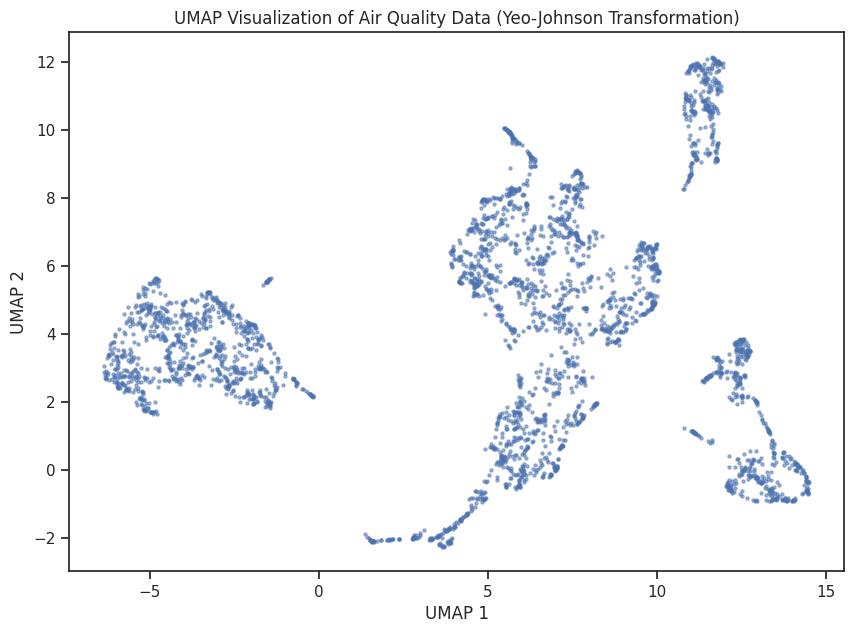

In [ ]:
reducer = umap.UMAP(n_neighbors=15,
                    min_dist=0.1,
                    n_components=2,
                    random_state=42)
X_umap = reducer.fit_transform(X_scaled_YJ)

plt.figure(figsize=(10, 7))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=5, alpha=0.5, cmap='viridis')
plt.title('UMAP Visualization of Air Quality Data (Yeo-Johnson Transformation)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

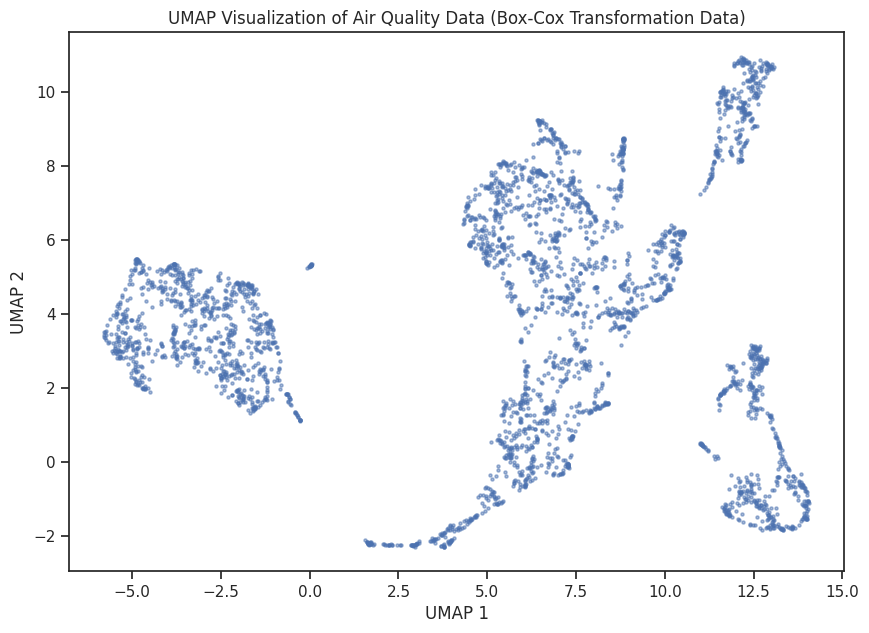

In [ ]:
reducer1 = umap.UMAP(n_neighbors=15,
                    min_dist=0.1,
                    n_components=2,
                    random_state=42)
X_umap1 = reducer1.fit_transform(X_scaled_BC)

plt.figure(figsize=(10, 7))
plt.scatter(X_umap1[:, 0], X_umap1[:, 1], s=5, alpha=0.5, cmap='viridis')
plt.title('UMAP Visualization of Air Quality Data (Box-Cox Transformation Data)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# Scoring Function

In [ ]:
def cluster_scoring(labels):
    mask = labels!=-1
    score = calinski_harabasz_score(X_umap[mask],labels[mask])
    score1 = davies_bouldin_score(X_umap[mask],labels[mask])
    print(f"CH Score: {score}, DB Score: {score1}")
    return score1

# KMeans

1.5414304
1.0371034
0.66285104
0.39471644
0.34188604
0.27278483
0.29213452
0.21263777
0.18031304
0.1401862
0.14520225
0.16161497
0.11156717


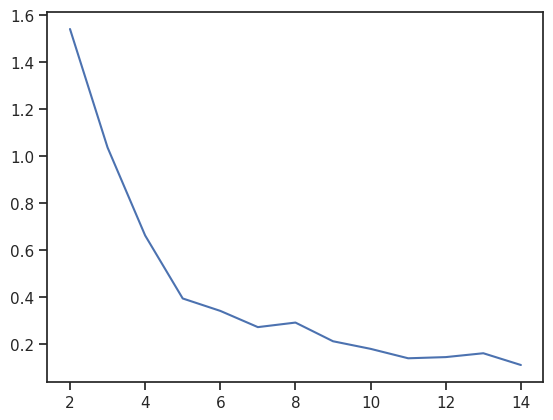

In [ ]:
d1_value=[]
d2_value=[]
d_value=[]
for i in range (2,15):
 cluster1=KMeans(n_clusters=i)
 cluster1.fit(X_umap)
 centroid = cluster1.cluster_centers_
 d_centroid = euclidean_distances(centroid)
 d1 = cluster1.inertia_/len(X_umap)
 avg_centroid = np.mean(d_centroid[d_centroid>0])
 d1_value.append(d1)
 d2_value.append(avg_centroid)
 d= d1/avg_centroid
 print(d)
 d_value.append(d)
plt.plot(range(2,15),d_value)

In [ ]:
scores = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled_YJ)
    score = silhouette_score(X_umap, km.labels_)
    scores.append(score)
    print(f"Silhouette Score for K={k}: {score}")
    cluster_scoring(km.labels_)
    print()

Silhouette Score for K=2: 0.01937047205865383
CH Score: 43.7537727355957, DB Score: 7.265380484968446

Silhouette Score for K=3: 0.12819169461727142
CH Score: 1078.80126953125, DB Score: 16.759806678274014

Silhouette Score for K=4: 0.1609041690826416
CH Score: 932.8882446289062, DB Score: 1.9732098409416317

Silhouette Score for K=5: 0.1505996137857437
CH Score: 970.0928344726562, DB Score: 1.686267931427468

Silhouette Score for K=6: 0.14539144933223724
CH Score: 1207.2593994140625, DB Score: 1.9549322316767173

Silhouette Score for K=7: 0.105960913002491
CH Score: 1138.7672119140625, DB Score: 2.170613127334257

Silhouette Score for K=8: 0.03042549267411232
CH Score: 710.320068359375, DB Score: 3.935581913449166

Silhouette Score for K=9: 0.03357318043708801
CH Score: 727.84423828125, DB Score: 2.7980931604392874

Silhouette Score for K=10: 0.19642870128154755
CH Score: 1393.66259765625, DB Score: 1.7797095520076955



# GAUSSIAN MIXTURE MODELS (GMM)

In [ ]:
gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(X_umap)
cluster_scoring(gmm_labels)

CH Score: 8511.8017578125, DB Score: 0.5379591494413022


np.float64(0.5379591494413022)

# Visual Plotting

In [ ]:
gmm_center = gmm.means_
gmm_center = pd.DataFrame(gmm_center, columns=["X","Y"])
gmm_center

X          Y
0  -3.649699   3.519942
1   5.702022   0.456627
2  11.379869  10.665850
3   6.810891   6.219394
4  12.832206   1.120833

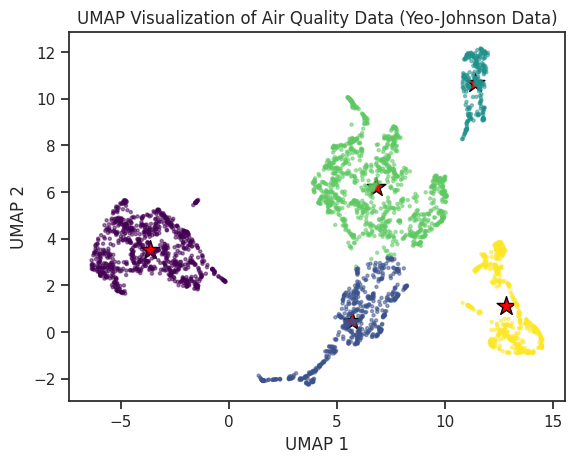

In [ ]:
plt.scatter(gmm_center["X"], gmm_center["Y"], s=200, c='red', marker='*', edgecolors='black', label='Centroids')
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=5, alpha=0.5, cmap='viridis',c=gmm_labels)
plt.title('UMAP Visualization of Air Quality Data (Yeo-Johnson Data)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# Set the Label to the Data Frame

In [ ]:
len(gmm_labels)

3269

In [ ]:
X_scaled_YJ["cluster_label"] = gmm_labels
data_new = data.copy()
data_new[cols_to_fillna] = data_copy
data_new["cluster_gmm"] = np.nan
for idx,items in X_scaled_YJ["O3"].items():
   data_new.loc[idx,"cluster_gmm"] = X_scaled_YJ.loc[idx, "cluster_label"]
data_new.dropna(inplace=True)

# Radar Chart(Spider Plot)

In [ ]:
features = cols_to_fillna
df_clean = data_new[data_new['cluster_gmm'] != -1]
centroids_gmm = df_clean.groupby('cluster_gmm')[features].mean().reset_index()
scaler_gmm = MinMaxScaler()
centroids_scaled_gmm = scaler_gmm.fit_transform(centroids_gmm[features])
centroids_scaled_df_gmm = pd.DataFrame(centroids_scaled_gmm, columns=features)
centroids_scaled_df_gmm['cluster'] = centroids_gmm['cluster_gmm']

In [ ]:

map_label = {
        0 : "The Fossil-Fuel Combustion Zone",
        1 : "The Dust Bowl",
        2 : "The Gridlock Zone",
        3 : "The Urban Lung",
        4 : "The Sun Struck Zone"}
def create_radar_chart(df_centroids, features):
    fig = go.Figure()
    for i in range(len(df_centroids)):
        values = df_centroids.iloc[i][features].tolist()
        values += [values[0]]
        feature_list = features + [features[0]]
        fig.add_trace(go.Scatterpolar(
            r=values,
            theta=feature_list,
            fill='toself',
            name=f'Cluster {map_label[int(df_centroids.iloc[i]["cluster"])]}',
            hovertemplate='%{theta}: %{r:.2f}<extra></extra>'))
    fig.update_layout(
        width=600,
        height=450,
        title=dict(
            text="Characteristic Profile of Each Pollution Cluster",
            font=dict(size=24),
            x=0.5,
            xanchor='center'),
        margin=dict(l=100, r=100, t=100, b=100),
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 1],
                tickfont=dict(size=12)),
            angularaxis=dict(
                tickfont=dict(size=14))),
        legend=dict(
            font=dict(size=14),
            yanchor="top",
            y=1,
            xanchor="left",
            x=1.1),
        showlegend=True,
        template="plotly_white")
    fig.show()

In [ ]:
create_radar_chart(centroids_scaled_df_gmm, features)

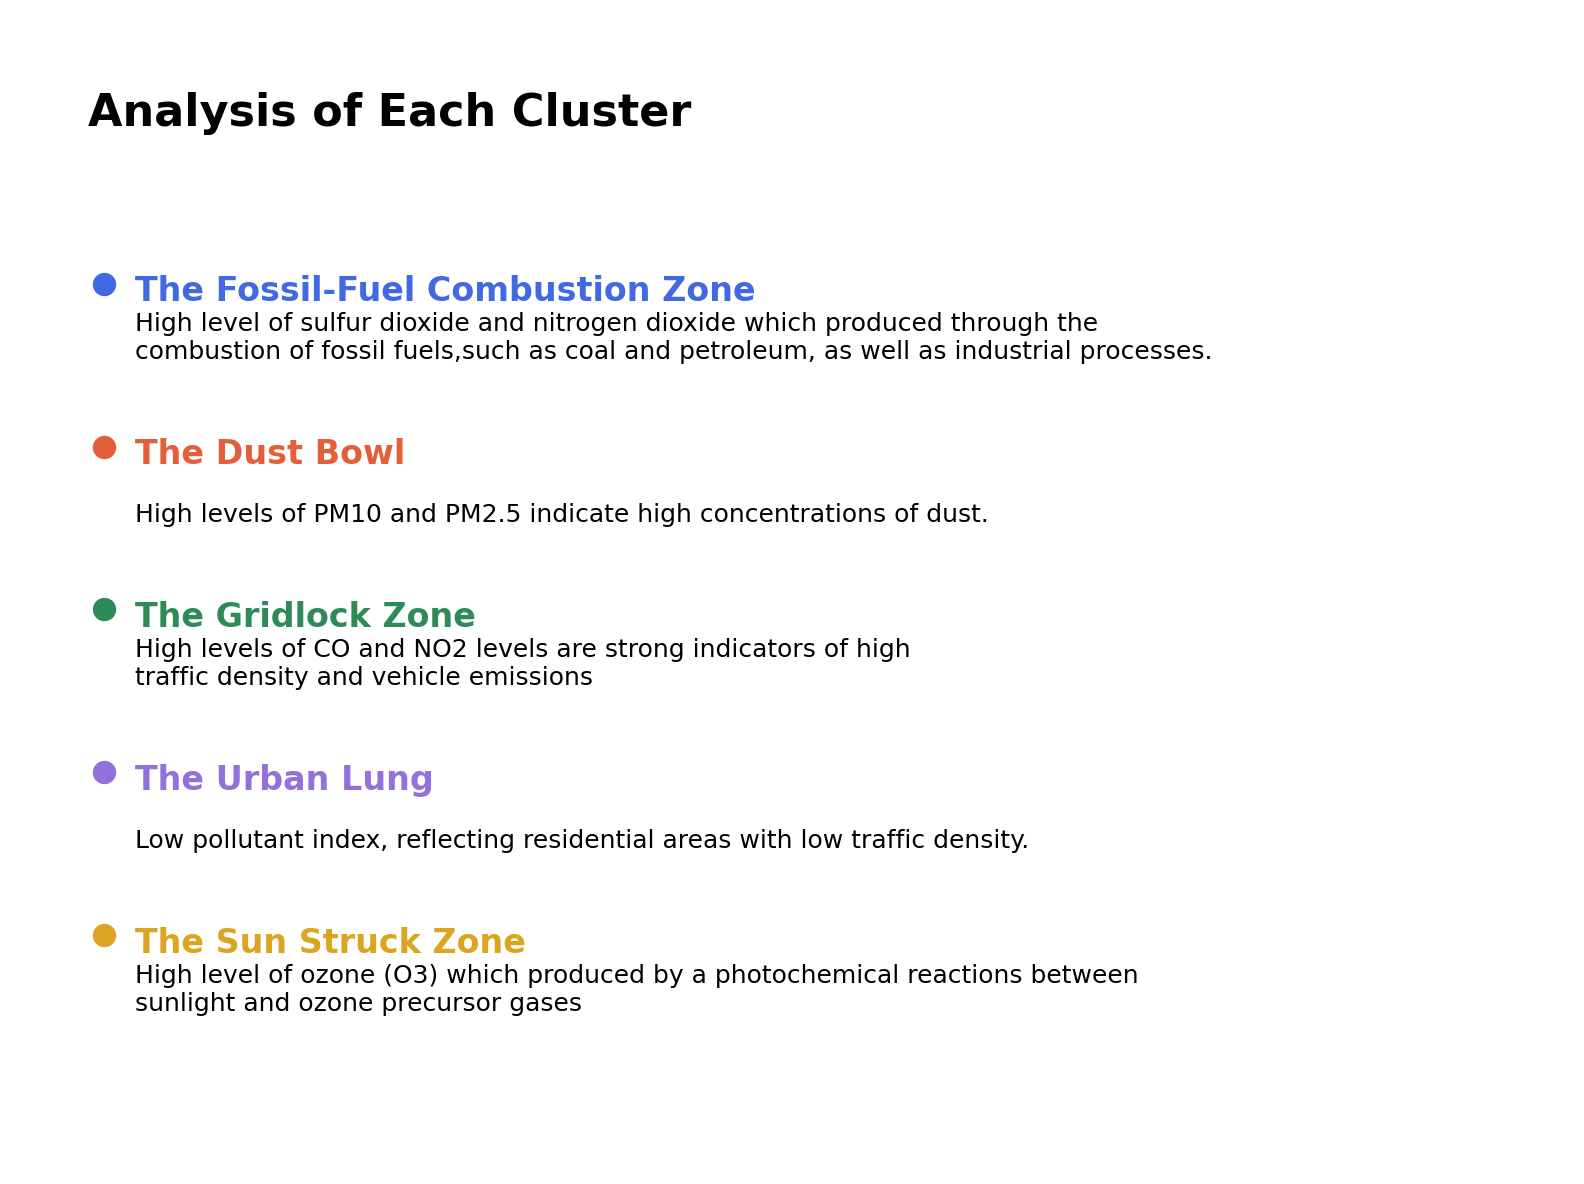

In [ ]:
def exp_each_cluster():
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.set_facecolor('white')
    cluster_colors = ['#4169E1', '#E35F39', '#2E8B57', '#9370DB', '#DAA520']
    title_text = "Analysis of Each Cluster"
    bullet_headers = [
        "The Fossil-Fuel Combustion Zone",
        "The Dust Bowl",
        "The Gridlock Zone",
        "The Urban Lung",
        "The Sun Struck Zone"
    ]
    bullet_descriptions = [
        "High level of sulfur dioxide and nitrogen dioxide which produced through the \ncombustion of fossil fuels,such as coal and petroleum, as well as industrial processes.",
        "High levels of PM10 and PM2.5 indicate high concentrations of dust.",
        "High levels of CO and NO2 levels are strong indicators of high \ntraffic density and vehicle emissions",
        "Low pollutant index, reflecting residential areas with low traffic density.",
        "High level of ozone (O3) which produced by a photochemical reactions between \nsunlight and ozone precursor gases"
    ]

    plt.text(0.05, 0.90, title_text, fontsize=32, fontweight='bold', color='black', transform=ax.transAxes)

    start_y = 0.75
    spacing = 0.14

    for i in range(5):
        current_y = start_y - (i * spacing)
        plt.scatter(0.06, current_y + 0.015, color=cluster_colors[i], s=250, transform=ax.transAxes)
        plt.text(0.08, current_y, bullet_headers[i],
                 fontsize=24, fontweight='bold', color=cluster_colors[i], transform=ax.transAxes)
        plt.text(0.08, current_y - 0.05, bullet_descriptions[i],
                 fontsize=18, fontweight='normal', color='black', transform=ax.transAxes)

    ax.axis('off')
    plt.tight_layout()
    plt.show()

exp_each_cluster()

In [ ]:
data_new["category"].unique()

array(['MODERATE', 'GOOD', 'UNHEALTHY'], dtype=object)

In [ ]:
data_new.groupby("category")["critical_pollutant"].value_counts()

category   critical_pollutant
GOOD       PM25                   218
           PM10                    91
           SO2                     41
           O3                      26
           NO2                      6
           CO                       1
MODERATE   PM25                  2262
           SO2                    156
           PM10                    82
           NO2                     54
           O3                      18
           PM_25                    2
UNHEALTHY  PM25                   310
           NO2                      1
           SO2                      1
Name: count, dtype: int64

In [ ]:
data_new.groupby("cluster_gmm")["category"].value_counts()

cluster_gmm  category 
0.0          MODERATE     796
             UNHEALTHY     62
             GOOD          35
1.0          MODERATE     491
             UNHEALTHY     58
             GOOD          24
2.0          MODERATE     226
             GOOD          36
             UNHEALTHY     10
3.0          MODERATE     758
             GOOD         200
             UNHEALTHY    117
4.0          MODERATE     303
             GOOD          88
             UNHEALTHY     65
Name: count, dtype: int64

# Classification Process

In [ ]:
le_cat = LabelEncoder()
data_new["cat_label"] = le_cat.fit_transform(data_new["category"])

In [ ]:
df_X = data_new.drop(["cat_label", "critical_pollutant", "station", "category", "max_value", "date"], axis=1)
df_y = data_new["cat_label"]
train1X, testX, train1y, testy = train_test_split(df_X, df_y, test_size=0.2, random_state=24, shuffle=True, stratify=df_y)
scaler = MinMaxScaler()
train_X = scaler.fit_transform(train1X)
test_X = scaler.transform(testX)

In [ ]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=24)
model_svm= svm.SVC(kernel="rbf",probability=True)
model_knn= KNeighborsClassifier(n_neighbors=5)
model_xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.5,
    max_depth=6,
    random_state=24,
    objective='multi:softprob', # Gunakan ini untuk multi-class
    eval_metric='mlogloss')
model_nb = MultinomialNB()

In [ ]:
models ={
"Random Forest": model_rf,
"SVM": model_svm,
"KNN": model_knn,
"XGBOOST": model_xgb,
"Naive Bayes": model_nb
}

In [ ]:
for item in models:
    model = models[item]
    model.fit(train_X,train1y)
    model_prediction= model.predict(test_X)
    model_probs = model.predict_proba(test_X)
    auc_score = roc_auc_score(testy, model_probs, multi_class='ovr')
    class_report = classification_report(model_prediction, testy)
    print(item)
    print(f"AUC SCORE: {auc_score}")
    print(class_report)

Random Forest
AUC SCORE: 0.9844734952466329
              precision    recall  f1-score   support

           0       0.88      0.97      0.93        70
           1       0.99      0.98      0.99       523
           2       0.97      0.98      0.98        61

    accuracy                           0.98       654
   macro avg       0.95      0.98      0.96       654
weighted avg       0.98      0.98      0.98       654

SVM
AUC SCORE: 0.9667267137857768
              precision    recall  f1-score   support

           0       0.75      0.92      0.83        63
           1       0.99      0.94      0.96       538
           2       0.82      0.96      0.89        53

    accuracy                           0.94       654
   macro avg       0.85      0.94      0.89       654
weighted avg       0.95      0.94      0.95       654

KNN
AUC SCORE: 0.9598202735833273
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        64
           1     

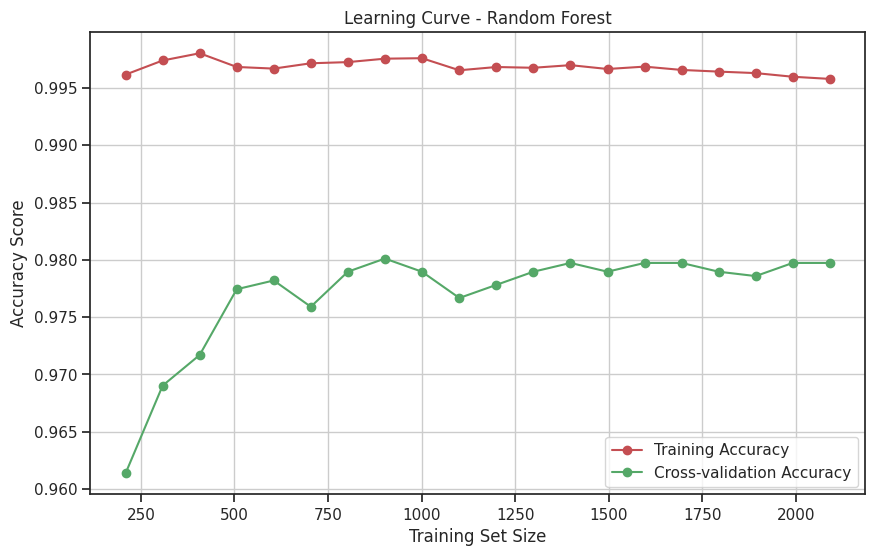

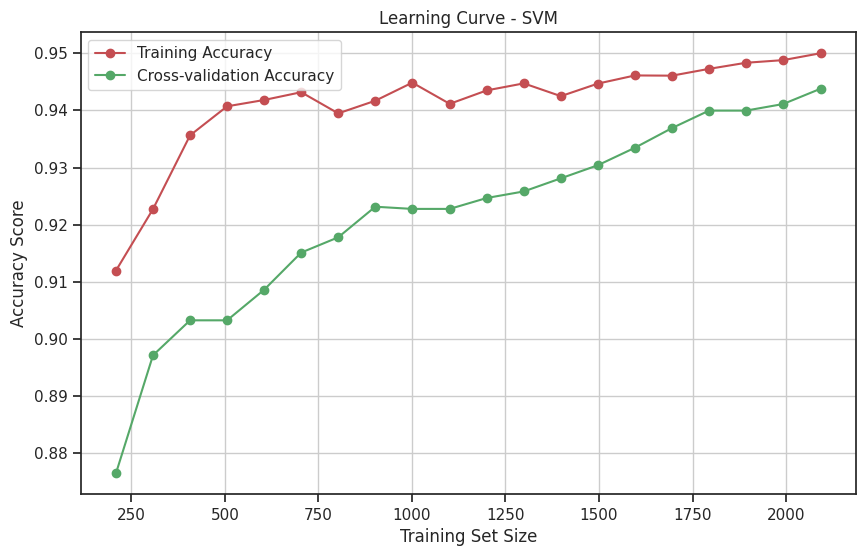

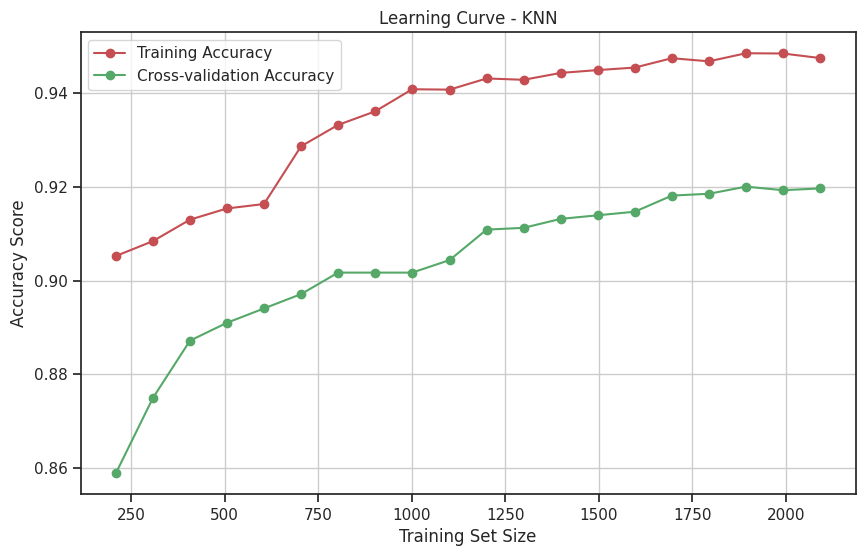

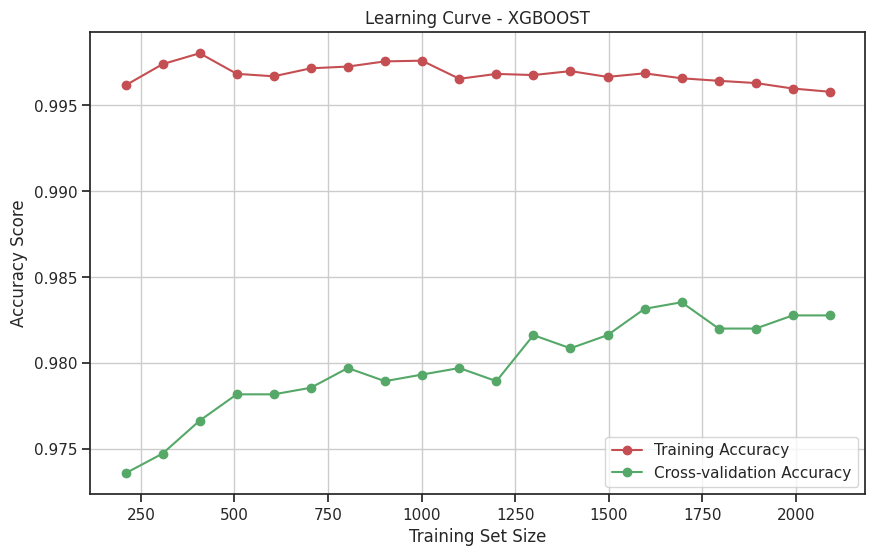

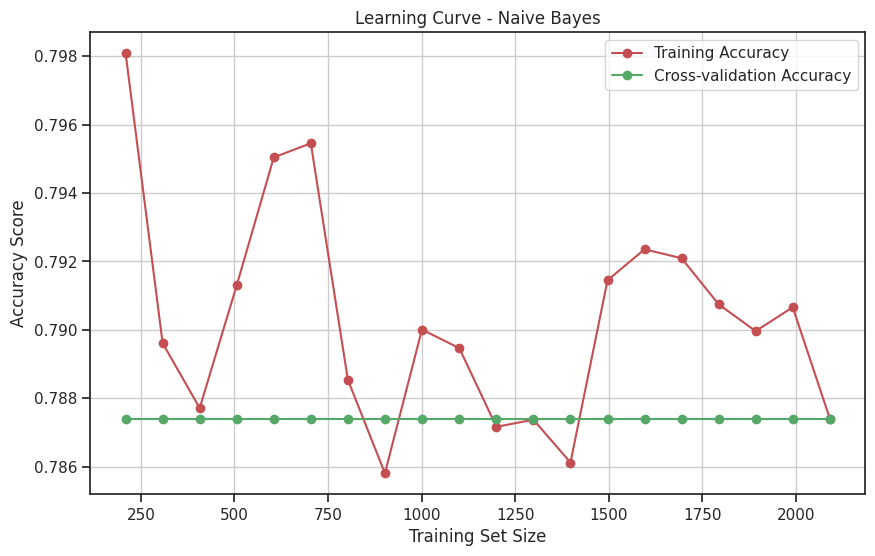

In [ ]:
for item in models:
    model = models[item]
    train_sizes = np.linspace(0.1, 1.0, 20)
    train_sizes, train_scores, val_scores = learning_curve(
        model, train_X, train1y,
        cv=5, scoring='accuracy',
        train_sizes=train_sizes,
        n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training Accuracy")
    plt.plot(train_sizes, val_mean, 'o-', color="g", label="Cross-validation Accuracy")
    plt.title(f"Learning Curve - {item}")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

In [ ]:
def cv_kfold(selected_model, df_X, df_y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_true_all = []
    y_pred_all = []
    acc_all = []
    for fold, (train_index, test_index) in enumerate(skf.split(df_X, df_y)):
        X_train, X_test = df_X.iloc[train_index], df_X.iloc[test_index]
        y_train, y_test = df_y.iloc[train_index], df_y.iloc[test_index]
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        model_fold = selected_model
        model_fold.fit(X_train_scaled, y_train)
        y_pred = model_fold.predict(X_test_scaled)
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        print(f"{fold+1} Fold:")
        acc_all.append (accuracy_score(y_test,y_pred))
        print(classification_report(y_test, y_pred))

    print("Final Report")
    print(f"Accuracy Mean: {np.mean(acc_all)}")
    print(classification_report(y_true_all, y_pred_all))

In [ ]:
selected_model = models["SVM"]
cv_kfold(selected_model, df_X, df_y, n_splits=5)

1 Fold:
              precision    recall  f1-score   support

           0       0.93      0.81      0.86        77
           1       0.95      0.98      0.96       515
           2       0.92      0.79      0.85        62

    accuracy                           0.94       654
   macro avg       0.93      0.86      0.89       654
weighted avg       0.94      0.94      0.94       654

2 Fold:
              precision    recall  f1-score   support

           0       1.00      0.73      0.84        77
           1       0.94      0.99      0.97       515
           2       0.93      0.85      0.89        62

    accuracy                           0.95       654
   macro avg       0.96      0.86      0.90       654
weighted avg       0.95      0.95      0.95       654

3 Fold:
              precision    recall  f1-score   support

           0       0.93      0.70      0.80        76
           1       0.94      0.98      0.96       515
           2       0.93      0.83      0.87        

# Simulation

In [ ]:
def run_prediction():
    pm10 = float(input("PM10 Rate: "))
    pm25 = float(input("PM2.5 Rate: "))
    so2 = float(input("SO2 Rate: "))
    co = float(input("CO Rate: "))
    o3 = float(input("O3 Rate: "))
    no2 = float(input("NO2 Rate: "))
    data_input = pd.DataFrame([[pm10,pm25,so2,co,o3,no2]], columns=cols_to_fillna)
    data_scaled = pd.DataFrame(pt.transform(data_input), columns=cols_to_fillna)
    data_umap = reducer.transform(data_scaled)
    label = gmm.predict(data_umap)[0]
    print(f"Cluster: {map_label[label]}")
    data_input["cluster_gmm"] = label
    data_pred = scaler.transform(data_input)
    category = le_cat.inverse_transform(model_svm.predict(data_pred))
    print(f"Category: {category[0]}")

In [ ]:
run_prediction()

PM10 Rate: 50
PM2.5 Rate: 72
SO2 Rate: 36
CO Rate: 15
O3 Rate: 50
NO2 Rate: 27
Cluster: The Sun Struck Zone
Category: MODERATE


In [ ]:
run_prediction()

PM10 Rate: 50
PM2.5 Rate: 72
SO2 Rate: 36
CO Rate: 15
O3 Rate: 23.8
NO2 Rate: 27
Cluster: The Urban Lung
Category: MODERATE
